In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [114]:
class MyRFECV(object):
    
    def __init__(self, estimator, step, cv, features):
        self.estimator = estimator
        self.step = step
        self.cv = cv
        self.features = features
        
    def _score(self, labels, probs):
        
        names = ['b', 'c', 'sud', 'gluon']
        roc_auc = utils.get_roc_auc_matrix(labels, probs, names, save_path=None, show=False)
        return roc_auc.values.mean()
        
    def _fit_step(self, data, features):
        sk = SklearnClassifier(self.estimator, features=None)
        folding = FoldingClassifier(sk, n_folds=self.cv, random_state=11, features=features)
        folding.fit_lds(data)
        importances = folding.feature_importances_
        indices = numpy.argsort(importances)[::-1]
        
        labels = data.target
        probs = folding.predict_proba(data.data)
        score = self._score(labels, probs)
        
        return features[indices], score
        
    def fit(self, data):
        features = self.features
        feature_list = []
        score_list = []
        
        while len(features) >= self.step:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
            features = features[:-self.step]
            
        if len(features) > 0:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
        return numpy.array(feature_list), numpy.array(score_list)

In [5]:
%matplotlib inline
import root_numpy
import pandas
import numpy
import matplotlib.pyplot as plt
from rep.data import LabeledDataStorage
#from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from rep.estimators import XGBoostClassifier, SklearnClassifier
import cPickle as pickle

## Read data

In [6]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=5.root', treename=treename)).dropna()
data_b = data_b[::90]
data_c = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('/home/mikhail91/jet_tagging_LHCb/datasets/type=0.root', treename=treename)).dropna()
data_light = data_light[::2]

In [7]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

In [8]:
full_data = pandas.concat([data_b, 
                           data_c, 
                           data_light[data_light.JetParton != 0], 
                           data_light[data_light.JetParton == 0]])

full_data['label'] = [0] * len(data_b) + \
                     [1] * len(data_c) + \
                     [2] * len(data_light[data_light.JetParton != 0]) + \
                     [3] * len(data_light[data_light.JetParton == 0])

In [16]:
names = ['b', 'c', 'sud', 'gluon']

In [9]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

# Multiclassification

## Data preprocessing

In [10]:
train_data = full_data[sv_features].values
labels = full_data['label'].values

## Train

In [86]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time multi_folding.fit(train_data, labels)

CPU times: user 13min 1s, sys: 1.42 s, total: 13min 2s
Wall time: 1min 44s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [87]:
multi_probs = multi_folding.predict_proba(train_data)

KFold prediction using folds column


## Results

In [88]:
import os, sys
sys.path.append('python')
import utils

In [89]:
from sklearn.metrics import log_loss

print 'Log loss is ', log_loss(labels, multi_probs)

Log loss is  0.59563031774


In [97]:
def get_learning_curve(clf, data, labels):

    n_estimators = clf.get_params()['base_estimator__n_estimators']
    staged_probas = clf.staged_predict_proba(data)

    from sklearn.metrics import log_loss
    log_loss_all = []
    for pred in staged_probas:
        log_loss_all.append(log_loss(labels, pred))

    x = numpy.arange(10, n_estimators + 10, 10)
    plt.plot(x, log_loss_all)
    plt.ylabel('Log loss')
    plt.xlabel('Iteration')
    plt.show()

KFold prediction using folds column


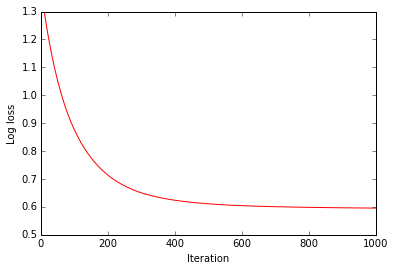

In [98]:
get_learning_curve(multi_folding, train_data, labels)

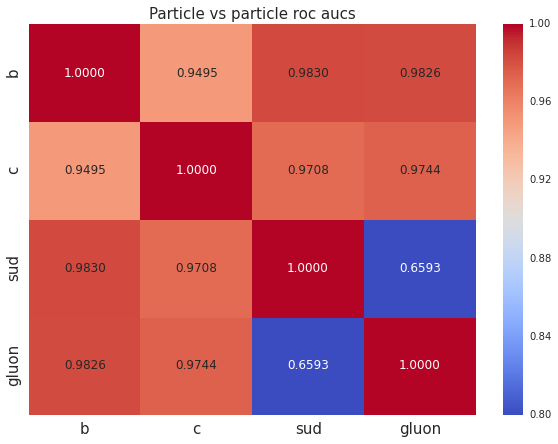

,b,c,sud,gluon
b,1.000000,0.949465,0.983033,0.982559
c,0.949465,1.000000,0.970798,0.974356
sud,0.983033,0.970798,1.000000,0.659258
gluon,0.982559,0.974356,0.659258,1.000000


In [102]:
roc_auc_baseline = utils.get_roc_auc_matrix(labels, multi_probs, names, save_path=None, show=True)
roc_auc_baseline

# Multiclassification + PCA

## Data preprocessing

In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components=train_data.shape[1])
pca_train_data = pca.fit_transform(train_data)

## Train

In [94]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
pca_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time pca_multi_folding.fit(pca_train_data, labels)

CPU times: user 12min 47s, sys: 1.38 s, total: 12min 48s
Wall time: 1min 41s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [95]:
pca_multi_probs = pca_multi_folding.predict_proba(pca_train_data)

KFold prediction using folds column


## Results

In [96]:
from sklearn.metrics import log_loss

print 'Log loss is ', log_loss(labels, pca_multi_probs)

Log loss is  0.591582871297


KFold prediction using folds column


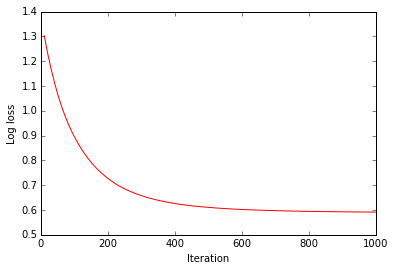

In [99]:
get_learning_curve(pca_multi_folding, pca_train_data, labels)

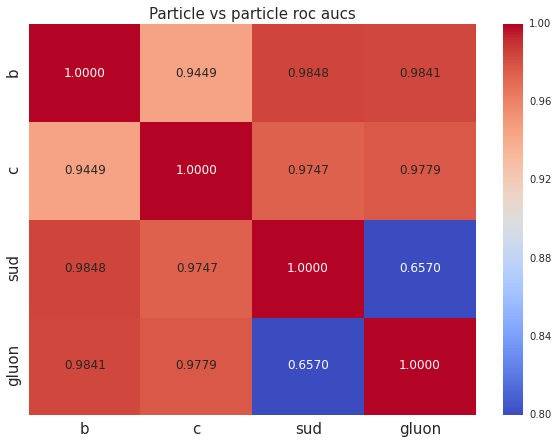

,b,c,sud,gluon
b,1.000000,0.944950,0.984794,0.984136
c,0.944950,1.000000,0.974737,0.977866
sud,0.984794,0.974737,1.000000,0.657014
gluon,0.984136,0.977866,0.657014,1.000000


In [103]:
pca_roc_aucs = utils.get_roc_auc_matrix(labels, pca_multi_probs, names, save_path=None, show=True)
pca_roc_aucs

In [104]:
pca_roc_aucs - roc_auc_baseline

,b,c,sud,gluon
b,0.000000,-0.004515,0.001761,0.001577
c,-0.004515,0.000000,0.003939,0.003509
sud,0.001761,0.003939,0.000000,-0.002244
gluon,0.001577,0.003509,-0.002244,0.000000


# Multiclass + features generation + features selection

## Data preprocessing

In [109]:
full_data['log_SVFDChi2'] = numpy.log(full_data['SVFDChi2'].values)
full_data['log_SVSumIPChi2'] = numpy.log(full_data['SVSumIPChi2'].values)
full_data['P_Sin'] = 0.5*full_data['SVMC'].values - (full_data['SVM'].values)**2/(2.*full_data['SVMC'].values)
full_data['Psv'] = full_data['SVPT'].values * full_data['P_Sin'].values
full_data['Psv2'] = full_data['P_Sin'].values / full_data['SVPT'].values
full_data['Mt'] = full_data['SVMC'].values - full_data['P_Sin'].values
full_data['QtoN'] = 1. * full_data['SVQ'].values / full_data['SVN'].values
    
new_features = ['log_SVFDChi2', 'log_SVSumIPChi2', 'P_Sin', 'Psv', 'Psv2', 'Mt', 'QtoN']

In [110]:
features = []
for ind1 in range(0, len(sv_features)):
    f1 = sv_features[ind1]
    for ind2 in range(ind1, len(sv_features)):
        f2 = sv_features[ind2]
        
        full_data[f1+'_mult_'+f2] = full_data[f1].values * full_data[f2].values
        full_data[f1+'_div_'+f2] = full_data[f1].values / (full_data[f2].values + 0.1)
        full_data[f2+'_div_'+f1] = full_data[f2].values / (full_data[f1].values + 0.1)
        features.append(f1+'_mult_'+f2)
        features.append(f1+'_div_'+f2)
        features.append(f2+'_div_'+f1)

        full_data['2'+f1+'_plus_'+f2] = (full_data[f1].values**2) + (full_data[f2].values**2)
        full_data['2'+f1+'_min_'+f2] = (full_data[f1].values**2) - (full_data[f2].values**2)
        features.append('2'+f1+'_plus_'+f2)
        features.append('2'+f1+'_min_'+f2)
        
new_features += features

In [111]:
new_train_data = full_data[sv_features + new_features].values

In [112]:
full_data_lds = LabeledDataStorage(full_data, labels)

In [131]:
forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=8, max_features=0.5)
feature_list, score_list = \
MyRFECV(estimator=forest, step=10, cv=2, features=numpy.array(sv_features+new_features)).fit(full_data_lds)

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


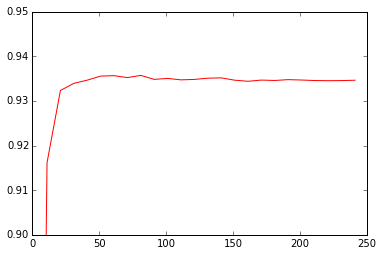

In [132]:
length = numpy.array([len(fs) for fs in feature_list])
plt.plot(length, score_list)
plt.ylim(0.90, 0.95)
plt.show()

In [133]:
sel_features = feature_list[score_list == score_list.max()][0]
len(sel_features)

81

In [134]:
sel_new_train_data = full_data[sel_features].values

## Train

In [135]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
sel_new_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time sel_new_multi_folding.fit(sel_new_train_data, labels)

CPU times: user 42min 37s, sys: 3.11 s, total: 42min 41s
Wall time: 5min 36s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Featu...', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 'Feature_78', 'Feature_79', 'Feature_80'],
         n_folds=2, parallel_profile=None, random_state=11)

In [136]:
sel_new_multi_probs = sel_new_multi_folding.predict_proba(sel_new_train_data)

KFold prediction using folds column


## Results

In [137]:
from sklearn.metrics import log_loss

print 'Log loss is ', log_loss(labels, sel_new_multi_probs)

Log loss is  0.565451468962


KFold prediction using folds column


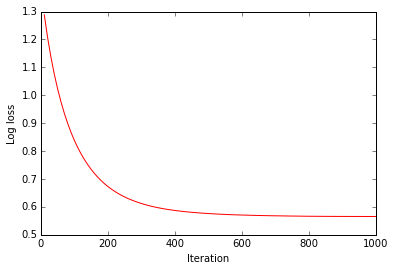

In [125]:
get_learning_curve(sel_new_multi_folding, sel_new_train_data, labels)

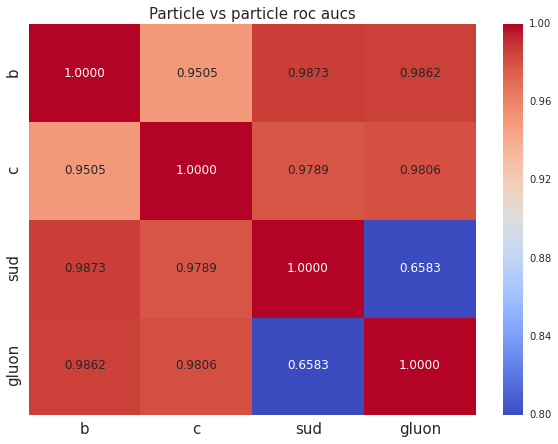

,b,c,sud,gluon
b,1.000000,0.950508,0.987296,0.986240
c,0.950508,1.000000,0.978871,0.980648
sud,0.987296,0.978871,1.000000,0.658307
gluon,0.986240,0.980648,0.658307,1.000000


In [138]:
sel_new_roc_aucs = utils.get_roc_auc_matrix(labels, sel_new_multi_probs, names, save_path=None, show=True)
sel_new_roc_aucs

In [139]:
sel_new_roc_aucs - roc_auc_baseline

,b,c,sud,gluon
b,0.000000,0.001043,0.004262,0.003681
c,0.001043,0.000000,0.008073,0.006292
sud,0.004262,0.008073,0.000000,-0.000951
gluon,0.003681,0.006292,-0.000951,0.000000
